In [8]:
%matplotlib inline

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('nba_time_series/raw/bos_2018.csv')

In [3]:
df.head()

,Season,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Box/OT,Box/OT.1,Attend.,MOV,URL,date
0,2018,8:01p,Boston Celtics,99,Cleveland Cavaliers,102,Box Score,NaN,"20,562",-3,/boxscores/201710170CLE.html,10/17/2017
1,2018,7:30p,Milwaukee Bucks,108,Boston Celtics,100,Box Score,NaN,"18,624",-8,/boxscores/201710180BOS.html,10/18/2017
2,2018,7:00p,Boston Celtics,102,Philadelphia 76ers,92,Box Score,NaN,"20,816",10,/boxscores/201710200PHI.html,10/20/2017
3,2018,7:30p,New York Knicks,89,Boston Celtics,110,Box Score,NaN,"18,624",21,/boxscores/201710240BOS.html,10/24/2017
4,2018,8:00p,Boston Celtics,96,Milwaukee Bucks,89,Box Score,NaN,"11,046",7,/boxscores/201710260MIL.html,10/26/2017


In [4]:
df = df[['MOV']]

In [5]:
df.head()

,MOV
0,-3
1,-8
2,10
3,21
4,7


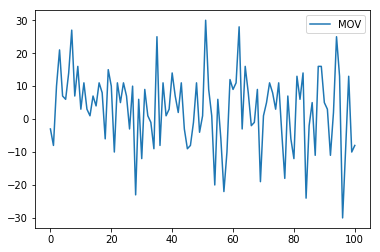

In [9]:
df.plot()

In [10]:
df.MOV.mean()

3.0396039603960396

In [11]:
df['lag'] = df.MOV.shift(1)

In [12]:
df.head()

,MOV,lag
0,-3,NaN
1,-8,-3.0
2,10,-8.0
3,21,10.0
4,7,21.0


In [ ]:
df.drop(['lag'], axis=1, inplace=True)

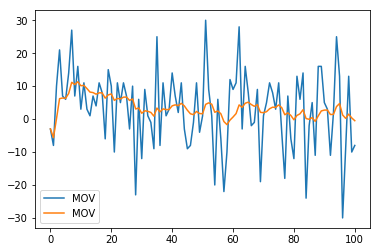

In [19]:
ax = df.plot()
df.ewm(alpha=0.1).mean().plot(ax=ax)

In [44]:
def mae(pred, targ): return (pred-targ).abs().mean()

In [23]:
targ = df['MOV']

In [61]:
# Method 1: predict previous day's value
pred = df['MOV'].shift(1).fillna(0)

In [62]:
pred.head()

0     0.0
1    -3.0
2    -8.0
3    10.0
4    21.0
Name: MOV, dtype: float64

In [63]:
mae(pred,targ)

13.188118811881187

In [64]:
def plot_preds():
    ax = df.plot()
    pred.plot(ax=ax)

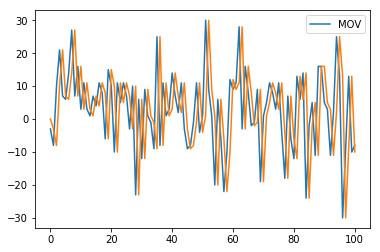

In [65]:
plot_preds()

In [66]:
# Method 2: expanding window
pred = df['MOV'].expanding().mean().shift(1).fillna(0)

In [67]:
pred.head()

0    0.000000
1   -3.000000
2   -5.500000
3   -0.333333
4    5.000000
Name: MOV, dtype: float64

In [68]:
mae(pred,targ)

9.010144481874349

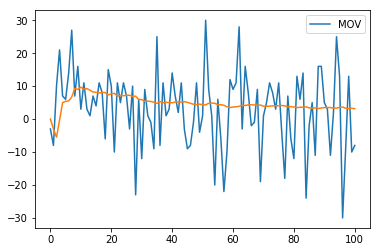

In [69]:
plot_preds()

In [70]:
# Just for shits...
pred = df['MOV'].expanding().median().shift(1).fillna(0)
mae(pred,targ)

9.158415841584159

In [71]:
# Method 3: rolling windows
pred = df['MOV'].rolling(window=5).mean().shift(1).fillna(0)

In [72]:
pred.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: MOV, dtype: float64

In [73]:
pred.tail()

96     6.4
97    -0.2
98     0.2
99     2.4
100   -4.6
Name: MOV, dtype: float64

In [74]:
mae(pred,targ)

9.88118811881188

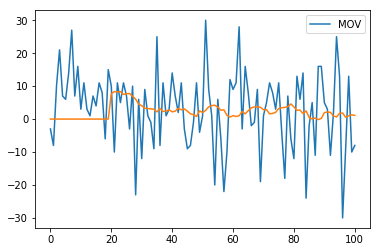

In [76]:
plot_preds()

In [77]:
ns = [3,5,10,20]
for n in ns:
    pred = df['MOV'].rolling(window=n).mean().shift(1).fillna(0)
    print(f'n: {n} mae: {mae(pred,targ)}')

n: 3 mae: 10.009900990099007
n: 5 mae: 9.88118811881188
n: 10 mae: 9.647524752475247
n: 20 mae: 9.554455445544555


Conclusion: the bigger the window the better, and the biggest possible (which is an expanding window) works best.

This suggests that more recent games should not figure much more in our predictions.

In [78]:
# Method 4: exponentially weighted average
pred = df['MOV'].ewm(alpha=0.1).mean().shift(1).fillna(0)

In [79]:
pred.head()

0    0.000000
1   -3.000000
2   -5.631579
3    0.136531
4    6.203257
Name: MOV, dtype: float64

In [80]:
mae(pred,targ)

9.14208708424596

In [81]:
alphas = [0.01, 0.03, 0.1, 0.3]
for alpha in alphas:
    pred = df['MOV'].ewm(alpha=alpha).mean().shift(1).fillna(0)
    print(f'alpha: {alpha} mae: {mae(pred,targ)}')

alpha: 0.01 mae: 9.007475434297982
alpha: 0.03 mae: 9.02264351924368
alpha: 0.1 mae: 9.14208708424596
alpha: 0.3 mae: 9.66791550389802


In [82]:
alpha=0.001
pred = df['MOV'].ewm(alpha=alpha).mean().shift(1).fillna(0)
print(f'alpha: {alpha} mae: {mae(pred,targ)}')

alpha: 0.001 mae: 9.009701735510562


The ewm with a very small alpha does just slightly better than the expanding window. Maybe the more recent games are just a touch more valuable.

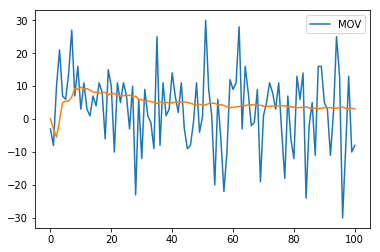

In [83]:
plot_preds()

The ewm appears to capture a slight downward trend over the course of the season. At this small of a value for alpha, it looks very similar to the expanding window.